I do some experiments here for myself.

In [11]:
import numpy
import pandas
import random

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

from utils import util

In [12]:
data = pandas.read_csv(util.dataset_filename)
data.drop(['customerID'], axis=1, inplace=True)

data[util.target_column] = data[util.target_column].replace(['Yes', 'No'], [1.0, 0.0])
data = util.integrating_numerical_column(util.numerical_columns[0], data)
data = util.standard_rescaling(util.numerical_columns, data)
data = util.one_hot_encoding(util.categorized_columns, data)

In [13]:
# from sklearn.datasets import make_classification
# from sklearn.model_selection import KFold
# # generate 2 class dataset
# X, y = make_classification(n_samples=7043, n_classes=2, weights=[0.73, 0.27], flip_y=0,
# random_state=1)

# kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# for train_ix, test_ix in kfold.split(X):

#     train_X, test_X = X[train_ix], X[test_ix]
#     train_y, test_y = y[train_ix], y[test_ix]

#     train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
#     test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

In [14]:
# stratification
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)


In [15]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

X = data.drop(util.target_column, axis=1)
y = data[util.target_column]

steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.513


In [107]:
params = (60, 30, 10)

class autoencoder(nn.Module):
    def __init__(self, input_size=47, latent_size=2, dropout_prob=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, params[0]), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(params[0], params[1]), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(params[1], params[2]), nn.ReLU(),
            nn.Linear(params[2], latent_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, params[2]), nn.ReLU(),
            nn.Linear(params[2], params[1]), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(params[1], params[0]), nn.ReLU(),
            nn.Linear(params[0], input_size),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


encoder_model = autoencoder()
# encoder_model.load_state_dict(torch.load('data/encoder.pth'))
encoder_model.to(util.device)
encoder_loss = nn.MSELoss().to(util.device)
encoder_optimizer = torch.optim.RMSprop(encoder_model.parameters(), lr=1e-4)

tensor = torch.tensor(data.values, device=util.device, dtype=torch.float32)
train_dataset = TensorDataset(tensor, tensor)
train_dataset = DataLoader(train_dataset, batch_size=10, shuffle=False)



In [108]:

for epoch in range(200):
    error = 0
    for inp, target in train_dataset:
        vector, encoder_out = encoder_model(inp)
        encoder_ls = encoder_loss(encoder_out, target)
        encoder_optimizer.zero_grad()
        encoder_ls.backward()
        encoder_optimizer.step()
        error += encoder_ls.item()
    print(error)

189.5988553315401
137.08587349951267
108.17097982764244
93.74986984580755
87.75872087478638
83.95119831711054
82.2416443824768
81.39498593658209
80.86455834656954
80.52205358445644
80.28300059586763
80.09704185277224
79.93096706271172
79.76889023184776
79.60734874755144
79.44293650239706
79.2682341337204
79.07691569626331
78.8693028613925
78.64683414250612
78.4031098857522
78.14364592730999
77.87638635188341
77.60931062698364
77.35620126128197
77.11831982433796
76.88731899857521
76.65494424849749
76.45093493908644
76.24407509714365
76.04299662262201
75.8663658797741
75.7028529420495
75.54800160229206
75.40281759947538
75.26652448624372
75.13947254419327
75.01312557607889
74.8952359482646
74.79035343974829
74.69178234785795
74.59942758828402
74.51333325356245
74.42951046675444
74.34778528660536
74.26867967098951
74.18871457129717
74.10915680974722
74.03224100917578
73.95355947315693
73.87299259006977
73.78796473890543
73.69620191305876
73.59200195223093
73.46892261505127
73.316903881728

In [109]:
torch.save(encoder_model.state_dict(), 'data/encoder.pth')

In [114]:
batch_size = 5

data_loader = DataLoader(TensorDataset(tensor, tensor), batch_size=batch_size, shuffle=False)

with torch.no_grad():
    encoded_data_c0 = []
    encoded_data_c1 = []
    for inp, _ in data_loader:
        latent_vectors, _ = encoder_model(inp)
        if inp[0,3] == 0:
            encoded_data_c0.append(latent_vectors.cpu().numpy()[0])
        else:
            encoded_data_c1.append(latent_vectors.cpu().numpy()[0])


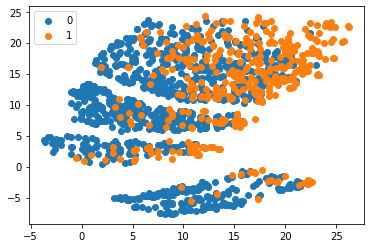

In [115]:
plt.scatter(numpy.array(encoded_data_c0)[:,0], numpy.array(encoded_data_c0)[:,1], label='0')
plt.scatter(numpy.array(encoded_data_c1)[:,0], numpy.array(encoded_data_c1)[:,1], label='1')
# show a legend
plt.legend()
# show the plot
plt.show()

Overlapping!